In [1]:
import argparse
import csv
from datetime import datetime

import numpy as np
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.utils import compute_class_weight

import sys
sys.path.append('../')
import data_hh
import models
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import copy

In [81]:
DECOMPOSED_ACTIVITIES_LIST = list(data_hh.cookActivities['hh102'].keys())
ORI_ACTIVITIES_LIST = data_hh.activitiesList
def visualize_cm(cm_path, is_rf=False):
    cm_raw = np.load(cm_path)
    cm = cm_raw[:-1 , :]
    labels_idx = cm_raw[-1, :]
    if not is_rf:    
        model_name, dataset_name = cm_path.split('/')[-1].split('-')[:2]

        activities_list = list(data_hh.cookActivities[dataset_name].keys())
        labels = [activities_list[idx] for idx in labels_idx]
        cm_df = pd.DataFrame(cm, index = labels, columns= labels)


    else:
        model_name = 'Random_Forest'
        dataset_name = 'hh102'
        cm_df = pd.DataFrame(cm, index = labels_idx, columns= labels_idx)
        cm_df = cm_df.astype(int)

        cm_df = cm_df[(cm_df != 0).any(axis=0)]
        cm_df = cm_df.loc[: , (cm_df != 0).any(axis=0)]
        
        labels = cm_df.index
        
        # cm_out = copy.deepcopy(cm_df)
    cm_df[labels] = cm_df[labels].apply(lambda x: x /np.sum(x) if np.sum(x) > 0 else x)
        
    
    plt.figure(figsize = (20,12))
    sn.heatmap(cm_df, annot=True)
    plt.title(f'Model: {model_name} Dataset: {dataset_name}', fontsize=20)
    # plt.xticks(rotation=45)
    plt.xlabel('Actual Activity', fontsize=15)
    plt.ylabel('Predicted Activity', fontsize=15)
    plt.savefig(cm_path.rsplit('/', 1)[0] + '/confusion_matrix.png', bbox_inches='tight', dpi=150)
    
    return cm_df

def extract_misclassfied_results(cm_raw):
    result = cm_raw.apply(lambda x : dict(x[x != 0]))
    nested_classi_result = dict(result)

    classification_result = []
    for k, v in nested_classi_result.items():
        for k1, v1 in v.items():
            if k != k1:
                classification_result.append({'Actual': k, 'Predicted': k1, 'False rate': v1})

    class_df = pd.DataFrame(classification_result)
    class_df.sort_values(by='False rate', ascending=False, inplace=True)
    class_df.reset_index(drop=True, inplace=True)
    return class_df

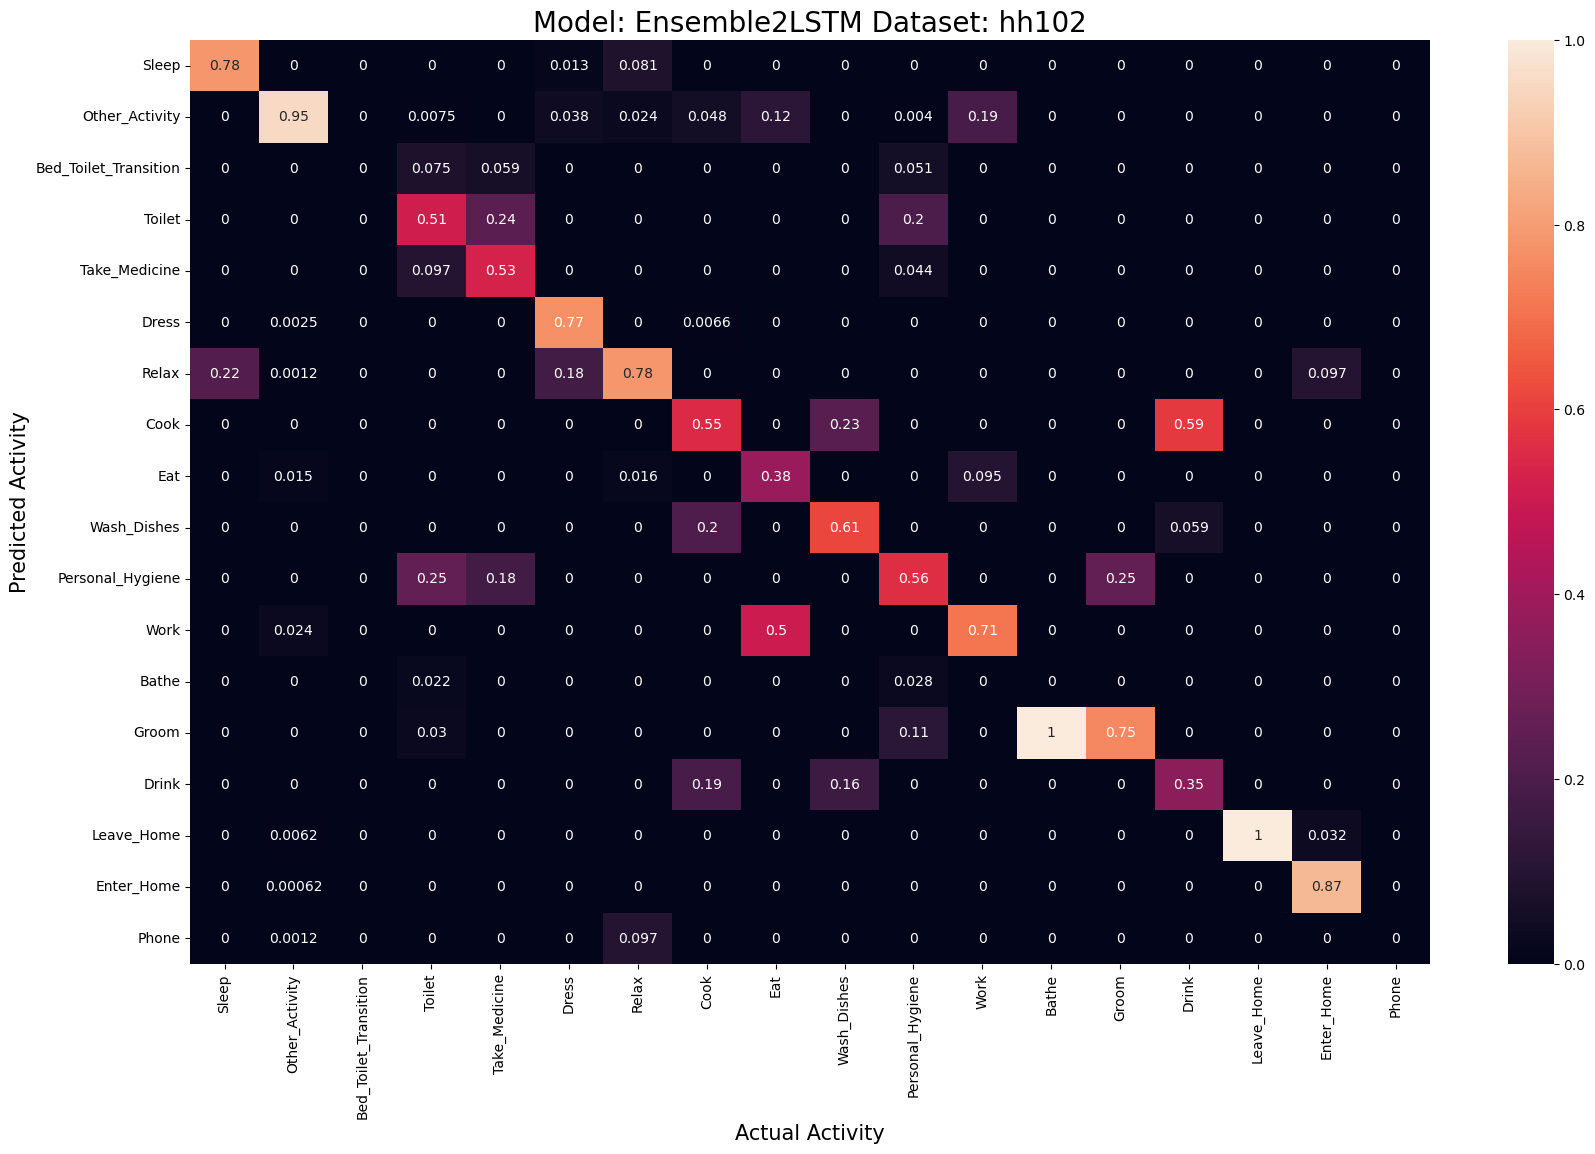

In [6]:
cm_raw = visualize_cm('../tmp/checkpoint/Ensemble2LSTM-20221027-192848/Ensemble2LSTM-hh102-fold-3-cm.npy')

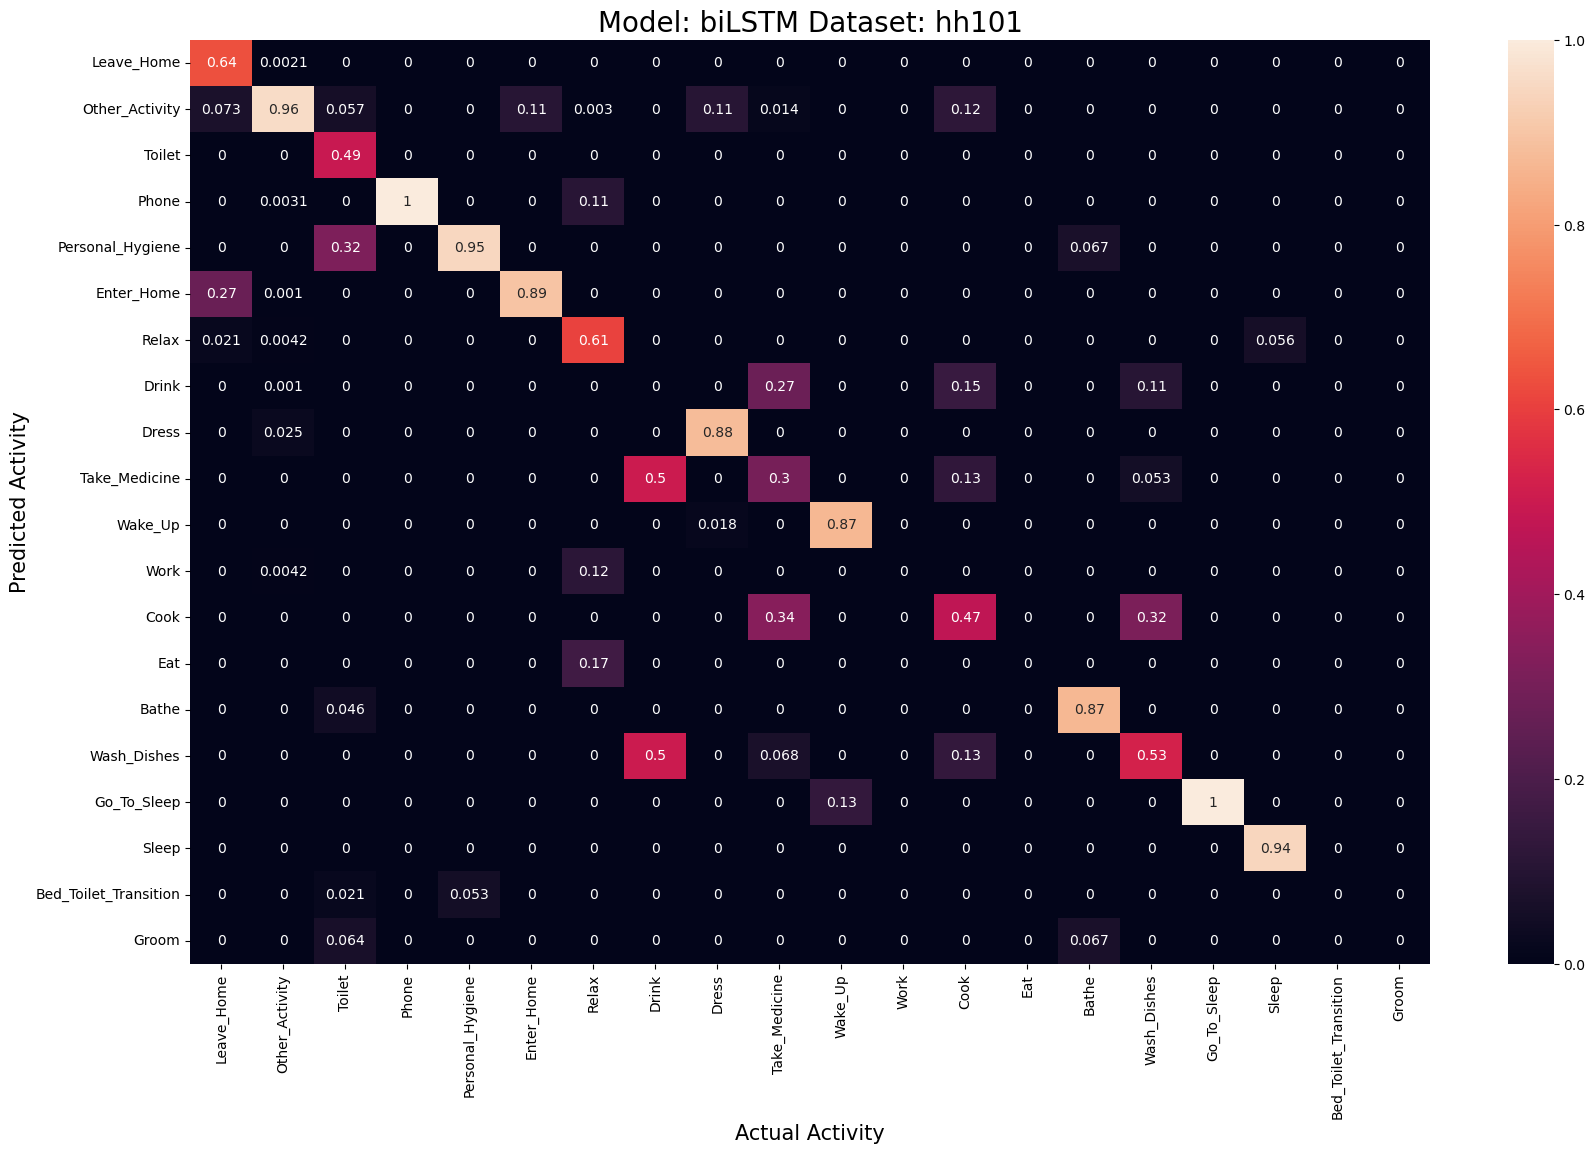

In [3]:
cm_raw = visualize_cm('../tmp/checkpoint/biLSTM-20221113-101826/biLSTM-hh101-fold-1-cm.npy')

In [7]:
extract_misclassfied_results(cm_raw)

,Acutal,Predicted,Score
0,Bathe,Groom,1.000000
1,Drink,Cook,0.588235
2,Eat,Work,0.500000
3,Toilet,Personal_Hygiene,0.253731
4,Groom,Personal_Hygiene,0.250000
5,Take_Medicine,Toilet,0.235294
6,Wash_Dishes,Cook,0.228070
7,Sleep,Relax,0.216216
8,Cook,Wash_Dishes,0.204846
9,Personal_Hygiene,Toilet,0.200000


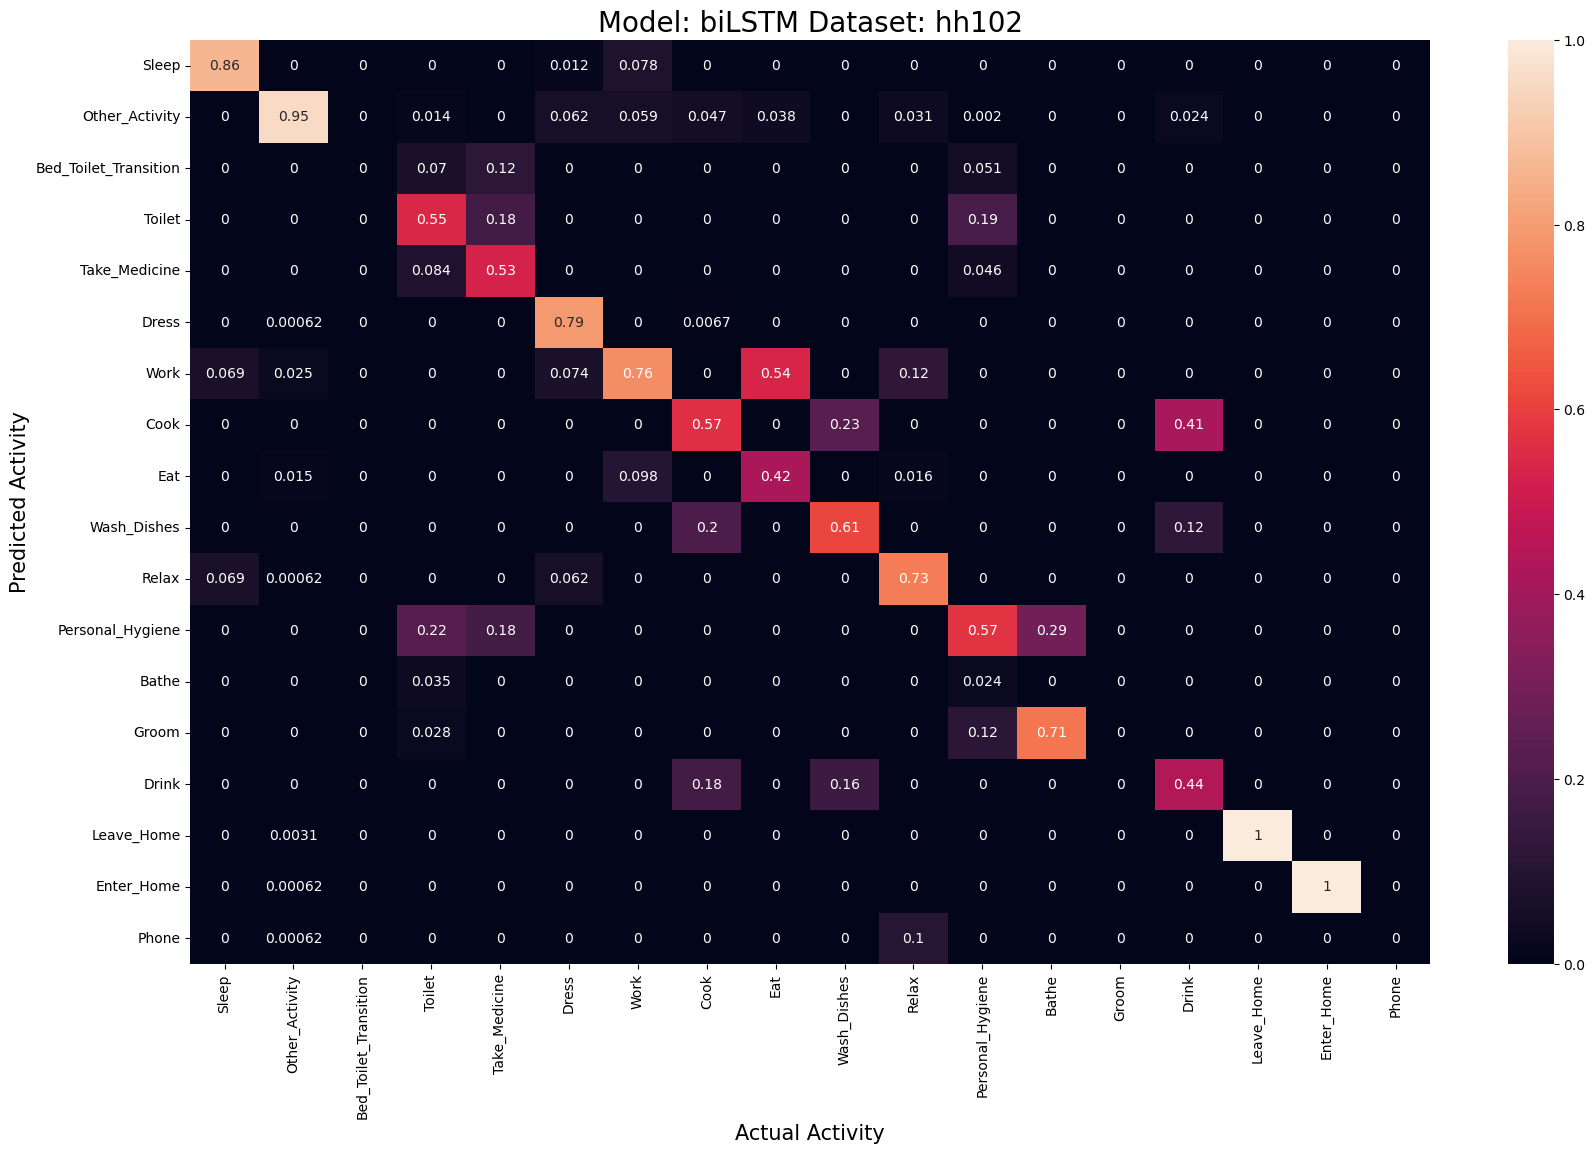

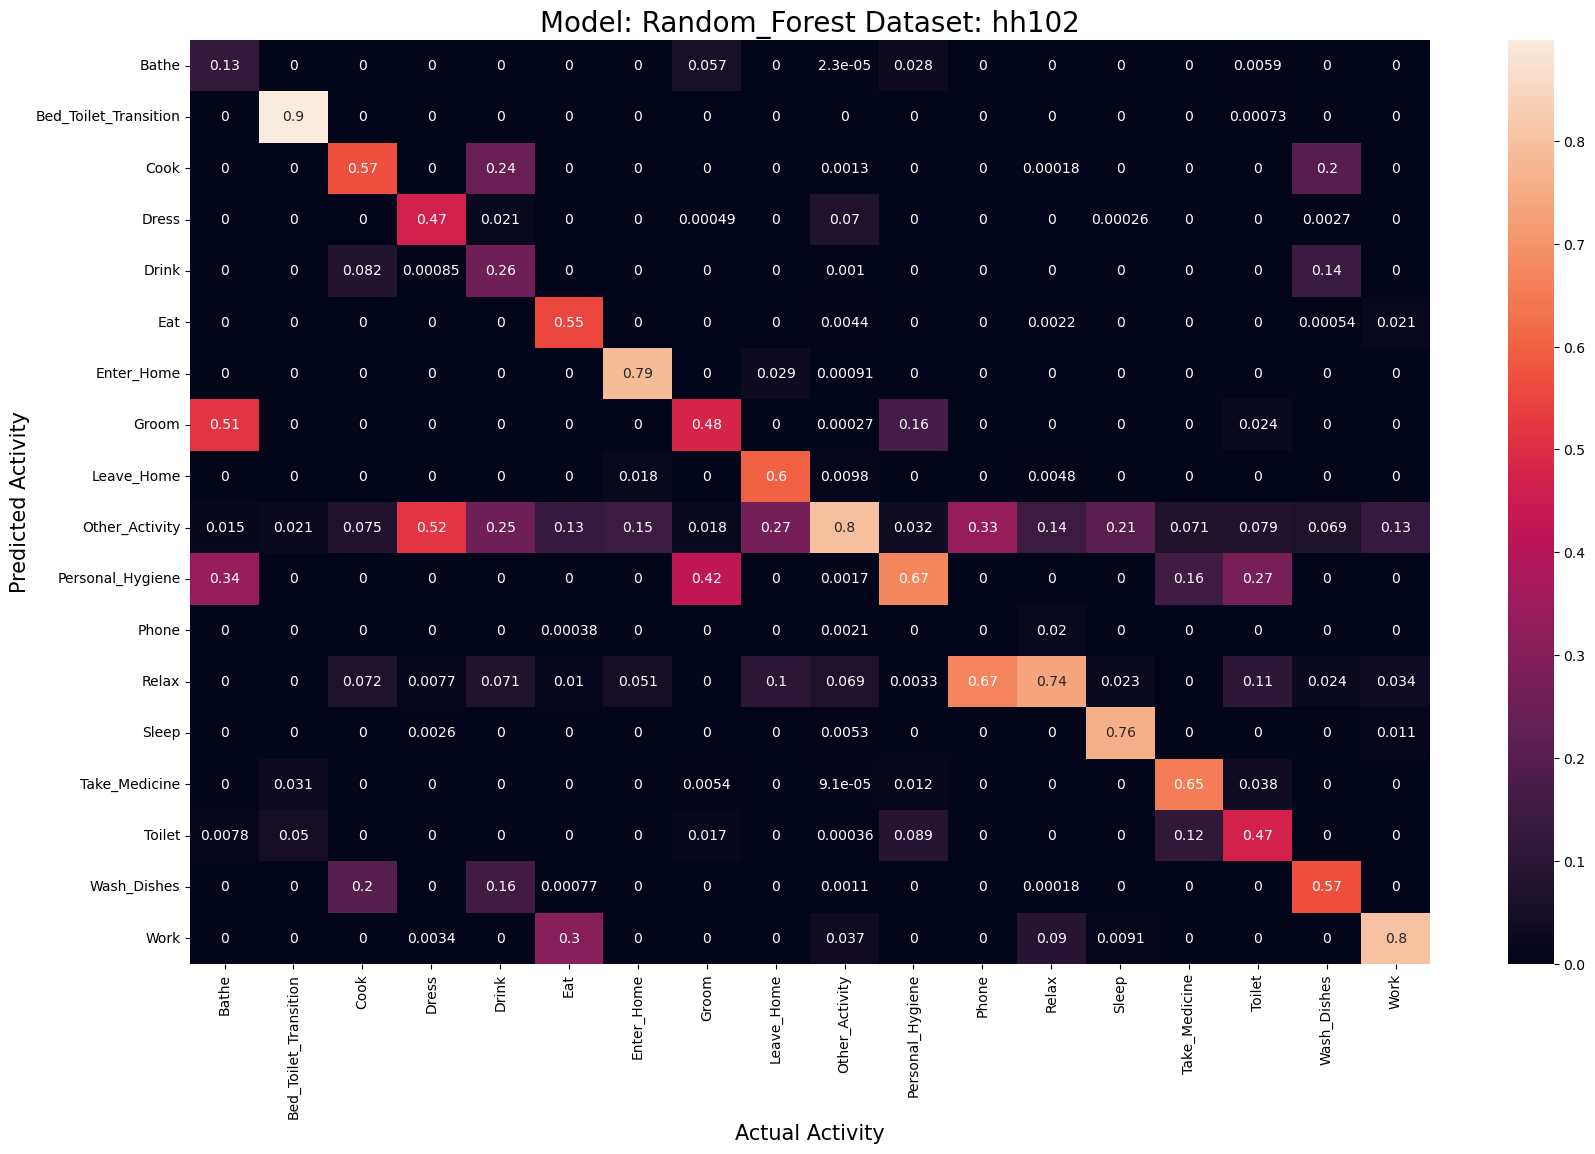

In [72]:
lstm_cm_raw = visualize_cm('../tmp/checkpoint/biLSTM-20221113-110402/biLSTM-hh102-fold-1-cm.npy')
rf_cm_raw = visualize_cm('../code/AL-Smarthome/rf-cm.npy', is_rf=True)

In [82]:
lstm_misclassified = extract_misclassfied_results(lstm_cm_raw)
lstm_misclassified['RF False Rate'] = lstm_misclassified.apply(lambda x: rf_cm_raw[x['Actual']][x['Predicted']], axis=1)
lstm_misclassified['Diff'] = lstm_misclassified['False rate'] - lstm_misclassified['RF False Rate']
lstm_misclassified.sort_values(by=['Diff'], ascending=False).head(10)

,Actual,Predicted,False rate,RF False Rate,Diff
1,Eat,Work,0.538462,0.302566,0.235895
0,Bathe,Groom,0.714286,0.513820,0.200466
2,Drink,Cook,0.414634,0.242233,0.172401
14,Take_Medicine,Bed_Toilet_Transition,0.117647,0.000000,0.117647
7,Personal_Hygiene,Toilet,0.187879,0.088910,0.098969
8,Cook,Drink,0.178971,0.082315,0.096656
16,Relax,Phone,0.101562,0.020269,0.081293
17,Work,Eat,0.098039,0.020951,0.077088
20,Dress,Work,0.074074,0.003413,0.070661
21,Toilet,Bed_Toilet_Transition,0.069930,0.000734,0.069196


0.5138199858256556

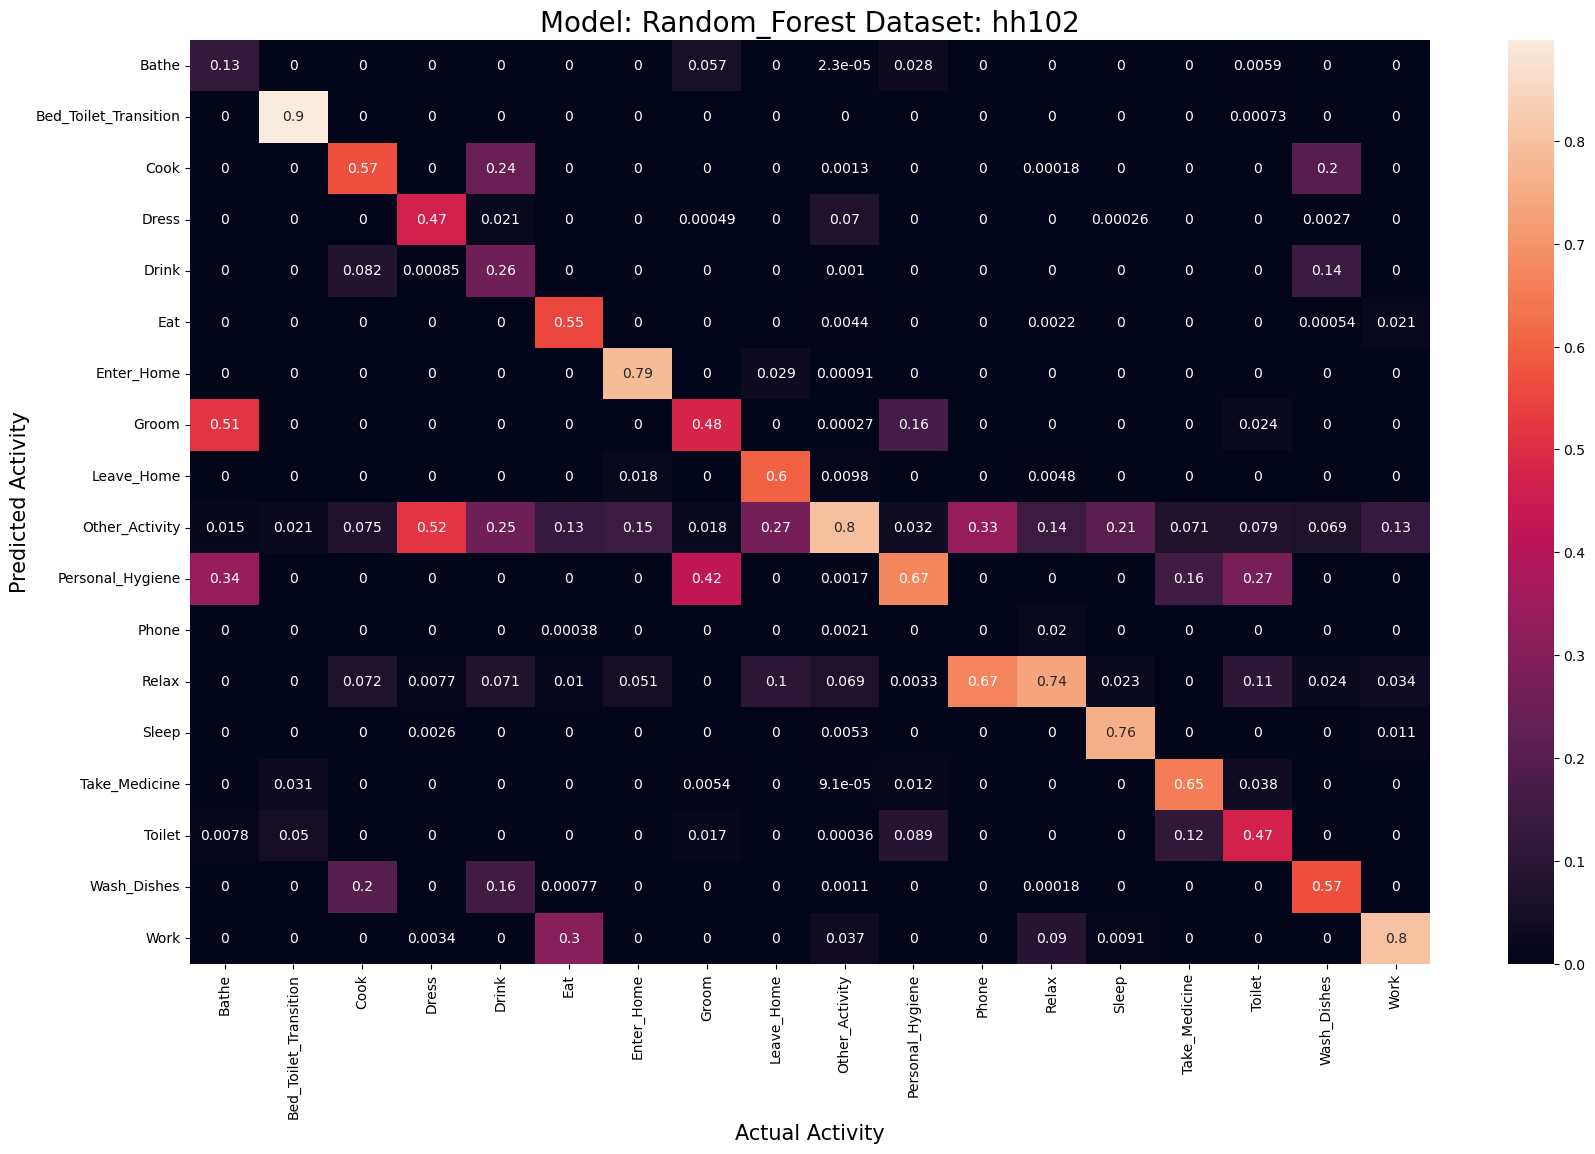

In [64]:
rf_cm_raw = visualize_cm('../code/AL-Smarthome/rf-cm.npy', is_rf=True)
rf_cm_raw['Bathe']['Groom']